In [1]:
import numpy as np
import pandas as pd

%load_ext autoreload
%autoreload 1
%aimport CodingFeatures
%aimport CodingTransformers

## Import and initialize train/test data and reference tables

In [2]:
# get annotated protein sequences
annotated = pd.read_csv('../data/BW25113proteome_dnaseq.csv') # get full sheet
annotated = annotated.drop_duplicates('seq').dropna() # drop duplicated proteins and missing DNA_seq
annotated['DNA_seq'] = annotated['DNA_seq'].apply(lambda x: x[3:]) # trim start codons from DNA_seq
annotated['start'] = annotated['start'] + 3 # increment sequence location index

training_data = annotated.loc[:,['DNA_seq','start']] # get sequence, location index
training_data['label'] = True # label

In [3]:
from CodingFeatures import codon_lookup

codon_table, c_lookup = codon_lookup()
AA_list = codon_table['aa'].unique()[1:]

In [4]:
import random
import re

# generate negative training set
acid_bag = list(zip(codon_table.index[3:],codon_table.f_tot[3:])) # zip AAs and total frequencies
acid_bag = [[x[0]]*int(x[1]*10000) for x in acid_bag] # expand AAs by frequencies
acid_bag = [x for X in acid_bag for x in X] # flatten list
# random.seed(23)
random.shuffle(acid_bag) # pseudo-randomize
stop_bag = ['TAA','TAA','TAA','TAA','TAA','TAA','TAG','TGA','TGA','TGA']

seq_random = []
# generate randomized sequences matching annotated lengths with known whole-genome codon biases
for L in annotated.length:
    tmp = [random.choice(acid_bag) for x in range(L-1)] + [random.choice(stop_bag)]
    seq_random.append(''.join(tmp))

Axes(0.125,0.125;0.775x0.775)
Axes(0.125,0.125;0.775x0.775)


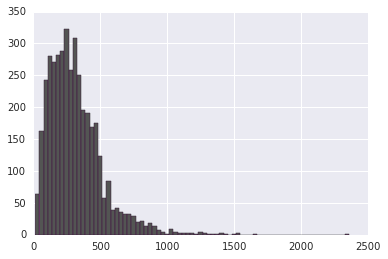

In [71]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# check length distributions
print(annotated.length.hist(bins=75, color='green'))
print(pd.Series(map(lambda x: len(x)/3,seq_random)).hist(bins=75,color='magenta',alpha=.33))

In [6]:
# reformat negative training set, label
training_random = pd.DataFrame(seq_random, columns=['DNA_seq'])
training_random['start'] = 0
training_random['label'] = False
# append to training_data
training_data = training_data.append(training_random, ignore_index=True)

In [7]:
from sklearn.cross_validation import train_test_split

train, test = train_test_split(training_data, train_size=.8, random_state=17)

In [8]:
from CodingFeatures import DNAAttributeConstruction, fragment_stop_delimited, fragment_windowed

train_object = DNAAttributeConstruction(list(train.DNA_seq), list(train.label), list(train.start)).decode_dna(c_lookup)
test_object = DNAAttributeConstruction(list(test.DNA_seq), list(test.label), list(test.start)).decode_dna(c_lookup)

## Feature extraction and model construction

In [9]:
from CodingFeatures import zerocross_pack, codon_bias_rms, aa_pack, class_pack, statpack1, statpack2
from CodingTransformers import ArrayFunctionTransformer
import sklearn as sk
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.ensemble import RandomForestClassifier as RCF

In [10]:
FU = FeatureUnion([
        ('aromatic', ArrayFunctionTransformer(statpack1,'aa_aromatic')),
        ('classes', ArrayFunctionTransformer(class_pack, 'aa_class')),
        ('hydro_z', ArrayFunctionTransformer(zerocross_pack, 'aa_hydrophob')),
        ('hydro_s', ArrayFunctionTransformer(statpack1, 'aa_hydrophob')),
        ('c_prefs', ArrayFunctionTransformer(statpack1, 'codon_pref')),
        ('c_bias', ArrayFunctionTransformer(codon_bias_rms, 'fragments', params=(c_lookup, AA_list))),
        ('aa_pack', ArrayFunctionTransformer(aa_pack, 'peptides', params=(AA_list,)))
    ], n_jobs=-1)

train_features = FU.transform(train_object)
test_features = FU.transform(test_object)

In [11]:
model = RCF(random_state=17,n_jobs=-1).fit(train_features, train_object.labels)

In [11]:
from sklearn.metrics import classification_report as clf_report

In [12]:
# print(model.score(test_object, test_object.labels))
print(clf_report(test_object.labels, model.predict(test_features), digits=3))

             precision    recall  f1-score   support

      False      0.644     0.766     0.700     11658
       True      0.703     0.566     0.627     11383

avg / total      0.673     0.667     0.664     23041



## GridSearch

In [12]:
from sklearn.grid_search import GridSearchCV

params = {'n_estimators':[10,20,50],
          'max_features':['sqrt','log2',None],
          'class_weight':['balanced','balanced_subsample',None]
         }

gridmodel = GridSearchCV(RCF(random_state=17,n_jobs=-1), cv=5, n_jobs=-1, param_grid=params)

In [ ]:
gridmodel.fit(train_features, train_object.labels)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=17, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'class_weight': ['balanced', 'balanced_subsample', None], 'n_estimators': [10, 20, 50], 'max_features': ['sqrt', 'log2', None]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [ ]:
for x in gridmodel.grid_scores_:
    print(x)
print('BestParams:  ',gridmodel.best_params_)

mean: 0.66491, std: 0.00597, params: {'class_weight': 'balanced', 'n_estimators': 10, 'max_features': 'sqrt'}
mean: 0.68597, std: 0.00304, params: {'class_weight': 'balanced', 'n_estimators': 20, 'max_features': 'sqrt'}
mean: 0.70773, std: 0.00358, params: {'class_weight': 'balanced', 'n_estimators': 50, 'max_features': 'sqrt'}
mean: 0.64849, std: 0.00541, params: {'class_weight': 'balanced', 'n_estimators': 10, 'max_features': 'log2'}
mean: 0.67378, std: 0.00255, params: {'class_weight': 'balanced', 'n_estimators': 20, 'max_features': 'log2'}
mean: 0.70035, std: 0.00311, params: {'class_weight': 'balanced', 'n_estimators': 50, 'max_features': 'log2'}
mean: 0.67536, std: 0.00315, params: {'class_weight': 'balanced', 'n_estimators': 10, 'max_features': None}
mean: 0.69374, std: 0.00293, params: {'class_weight': 'balanced', 'n_estimators': 20, 'max_features': None}
mean: 0.70875, std: 0.00168, params: {'class_weight': 'balanced', 'n_estimators': 50, 'max_features': None}
mean: 0.66249, s

In [ ]:
print(clf_report(test_object.labels, gridmodel.predict(test_features), digits=3))

             precision    recall  f1-score   support

      False      0.688     0.778     0.730     11658
       True      0.738     0.639     0.685     11383

avg / total      0.713     0.709     0.708     23041



### Round 2 GridSearch

In [13]:
from sklearn.grid_search import GridSearchCV

params = {'n_estimators':[50,100,150],
          'max_features':[None],
          'class_weight':['balanced','balanced_subsample']
         }

gridmodel2 = GridSearchCV(RCF(random_state=17,n_jobs=-1), cv=5, n_jobs=-1, param_grid=params)

In [ ]:
gridmodel2.fit(train_features, train_object.labels)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=17, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'class_weight': ['balanced', 'balanced_subsample'], 'n_estimators': [50, 100, 150], 'max_features': [None]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [ ]:
for x in gridmodel2.grid_scores_:
    print(x)
print('BestParams:  ',gridmodel2.best_params_)

mean: 0.70875, std: 0.00168, params: {'class_weight': 'balanced', 'n_estimators': 50, 'max_features': None}
mean: 0.71321, std: 0.00287, params: {'class_weight': 'balanced', 'n_estimators': 100, 'max_features': None}
mean: 0.71556, std: 0.00291, params: {'class_weight': 'balanced', 'n_estimators': 150, 'max_features': None}
mean: 0.70852, std: 0.00259, params: {'class_weight': 'balanced_subsample', 'n_estimators': 50, 'max_features': None}
mean: 0.71293, std: 0.00338, params: {'class_weight': 'balanced_subsample', 'n_estimators': 100, 'max_features': None}
mean: 0.71513, std: 0.00171, params: {'class_weight': 'balanced_subsample', 'n_estimators': 150, 'max_features': None}
BestParams:   {'class_weight': 'balanced', 'n_estimators': 150, 'max_features': None}


In [ ]:
print(clf_report(test_object.labels, gridmodel2.predict(test_features), digits=3))

             precision    recall  f1-score   support

      False      0.695     0.783     0.737     11658
       True      0.745     0.648     0.693     11383

avg / total      0.720     0.717     0.715     23041



### Round 3 GridSearch

In [17]:
from sklearn.grid_search import GridSearchCV

params = {'n_estimators':[400]
         }

gridmodel3 = GridSearchCV(RCF(random_state=17,n_jobs=-1,class_weight='balanced'), cv=5, n_jobs=-1, param_grid=params)

In [18]:
gridmodel3.fit(train_features, train_object.labels)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=17, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [400]}, pre_dispatch='2*n_jobs',
       refit=True, scoring=None, verbose=0)

In [19]:
for x in gridmodel3.grid_scores_:
    print(x)
print('BestParams:  ',gridmodel3.best_params_)

mean: 0.72726, std: 0.00321, params: {'n_estimators': 400}
BestParams:   {'n_estimators': 400}


In [20]:
print(clf_report(test_object.labels, gridmodel3.predict(test_features), digits=3))

             precision    recall  f1-score   support

      False      0.710     0.801     0.752     11658
       True      0.765     0.664     0.711     11383

avg / total      0.737     0.733     0.732     23041



In [ ]:
results = pd.DataFrame(test_object.frag_index, columns=['idg', 'idn'])
results['predict'] = gridmodel3.predict(test_features)
# results['predict'] = [random.choice([True,False]) for x in range(len(results))]

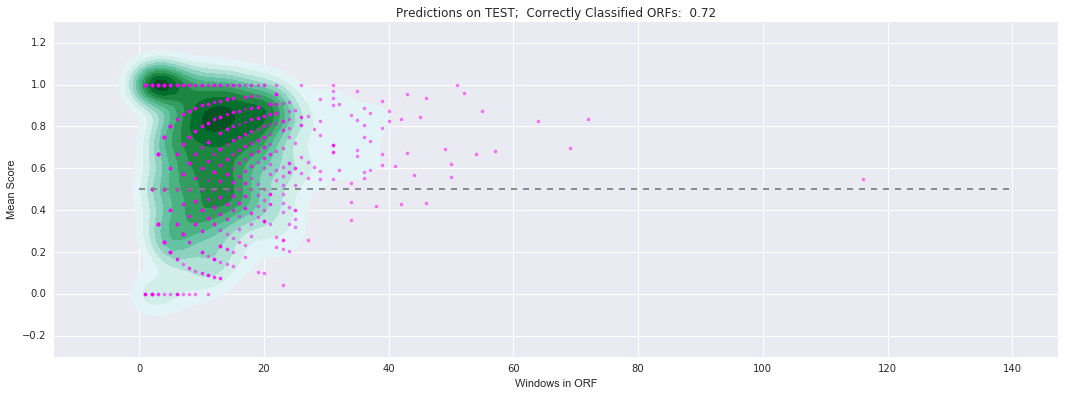

In [142]:
summary = pd.DataFrame()
summary['avg'] = results.predict.groupby(results.idg).mean()
summary['n'] = results.predict.groupby(results.idg).count()

# ax = summary.tail(-1).plot(kind='scatter', x='n', y='avg', )
fig,ax = plt.subplots(figsize=(18,6))
ax.set_title('Predictions on TEST;  Correctly Classified ORFs:  {0:.{1}f}'.format(summary[summary.avg >= .5].avg.count()/summary.shape[0],2))
ax.set_xlabel('Windows in ORF')
ax.set_ylabel('Mean Score')
ax.hlines(.5,0,140,linestyles='dashed', color='grey')
sns.kdeplot(summary.tail(-1)[['n','avg']], shade=True, shade_lowest=False, ax=ax)
ax.scatter(summary.n[1:], summary.avg[1:], color='magenta', alpha=.5, s=10)
